# Debiasing Word Embeddings: Neutralization and Equalization

`Description:`  

In this notebook, we explore and reduce gender bias in word embeddings using GloVe vectors. 

- Performed a word analogy task (e.g., "man : doctor :: woman : ?"), which helps reveal hidden gender biases in the embeddings.
- Measure gender bias using cosine similarity with a gender direction vector (g)
- Apply neutralization to make gender-neutral words like "doctor" and "receptionist" unbiased
- Use equalization to ensure gendered pairs like "man/woman" and "king/queen" are symmetrically aligned
- Visualize the effect of debiasing with cosine similarity charts  

This notebook is based on methods from the paper by [Boliukbasi et al., 2016](https://arxiv.org/abs/1607.06520).

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

In [73]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
            
    return words, word_to_vec_map

In [74]:
words, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

In [75]:
print(len(words))

400000


In [76]:
print(len(word_to_vec_map['king']))
word_to_vec_map['king']

50


array([ 0.50451 ,  0.68607 , -0.59517 , -0.022801,  0.60046 , -0.13498 ,
       -0.08813 ,  0.47377 , -0.61798 , -0.31012 , -0.076666,  1.493   ,
       -0.034189, -0.98173 ,  0.68229 ,  0.81722 , -0.51874 , -0.31503 ,
       -0.55809 ,  0.66421 ,  0.1961  , -0.13495 , -0.11476 , -0.30344 ,
        0.41177 , -2.223   , -1.0756  , -1.0783  , -0.34354 ,  0.33505 ,
        1.9927  , -0.04234 , -0.64319 ,  0.71125 ,  0.49159 ,  0.16754 ,
        0.34344 , -0.25663 , -0.8523  ,  0.1661  ,  0.40102 ,  1.1685  ,
       -1.0137  , -0.21585 , -0.15155 ,  0.78321 , -0.91241 , -1.6106  ,
       -0.64426 , -0.51042 ])

$$\text{CosineSimilarity(u, v)} = \frac {u \cdot v} {||u||_2 ||v||_2} = cos(\theta)$$

In [77]:
def cosine_similarity(u, v):
    if np.all(u == v):
        return 1
    
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    
    if np.isclose(norm_u * norm_v, 0, atol=1e-32):
        return 0  # Avoid division by zero
    
    return np.dot(u, v) / (norm_u * norm_v)

In [79]:
father = word_to_vec_map["father"]
mother = word_to_vec_map["mother"]
the = word_to_vec_map['the']
of = word_to_vec_map['of']

print(cosine_similarity(father, mother))
print(cosine_similarity(father, the))
print(cosine_similarity(of, the))

0.8909038442893615
0.5187136402036469
0.9026352642565105


## Word Analogy

In [80]:
def complete_analogy(word_a, word_b, word_c, word_to_vec_map):
    """
    Solves analogy: word_a is to word_b as word_c is to ?
    Example: 'man' : 'king' :: 'woman' : ?

    Arguments:
    word_a, word_b, word_c -- strings
    word_to_vec_map -- dictionary mapping words to GloVe vectors

    Returns:
    best_word -- word that best fits the analogy
    """
    word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()
    
    e_a, e_b, e_c = word_to_vec_map[word_a], word_to_vec_map[word_b], word_to_vec_map[word_c]
    target_vector = e_b - e_a + e_c

    max_similarity = -np.inf
    best_word = None

    for word, vec in word_to_vec_map.items():
        if word in [word_a, word_b, word_c]:
            continue

        sim = cosine_similarity(target_vector, vec)
        if sim > max_similarity:
            max_similarity = sim
            best_word = word

    return best_word

In [81]:
to_try = [
    ('italy', 'italian', 'spain'),
    ('india', 'delhi', 'japan'),
    ('man', 'woman', 'boy'),
    ('small', 'smaller', 'large')
]

for a, b, c in to_try:
    result = complete_analogy(a, b, c, words_to_vec_map)
    print(f"{a} : {b} :: {c} : {result}")

italy : italian :: spain : spanish
india : delhi :: japan : tokyo
man : woman :: boy : girl
small : smaller :: large : larger


## Debiasing Word Vectors
Bias exists when a word is gender-neutral in meaning but shows strong alignment with one gender

In [82]:
a, b, c = ('man', 'doctor', 'woman')
result = complete_analogy(a, b, c, word_to_vec_map)
print(f"{a} : {b} :: {c} : {result}")

man : doctor :: woman : nurse


Even though:
doctor is gender-neutral, the model associates 'woman' more with 'nurse' than 'doctor'

In [83]:
g = word_to_vec_map['woman'] - word_to_vec_map['man']
print(g)

[-0.087144    0.2182     -0.40986    -0.03922    -0.1032      0.94165
 -0.06042     0.32988     0.46144    -0.35962     0.31102    -0.86824
  0.96006     0.01073     0.24337     0.08193    -1.02722    -0.21122
  0.695044   -0.00222     0.29106     0.5053     -0.099454    0.40445
  0.30181     0.1355     -0.0606     -0.07131    -0.19245    -0.06115
 -0.3204      0.07165    -0.13337    -0.25068714 -0.14293    -0.224957
 -0.149       0.048882    0.12191    -0.27362    -0.165476   -0.20426
  0.54376    -0.271425   -0.10245    -0.32108     0.2516     -0.33455
 -0.04371     0.01258   ]


In [84]:
print ('List of names and their similarities with constructed vector:')

# girls and boys name
name_list = ['john', 'marie', 'sophie', 'ronaldo', 'priya', 'rahul', 'danielle', 'reza', 'katy', 'yasmin']

for w in name_list:
    print (w, cosine_similarity(word_to_vec_map[w], g))

List of names and their similarities with constructed vector:
john -0.23163356145973724
marie 0.315597935396073
sophie 0.31868789859418784
ronaldo -0.31244796850329437
priya 0.17632041839009402
rahul -0.1691547103923172
danielle 0.24393299216283895
reza -0.07930429672199553
katy 0.2831068659572615
yasmin 0.23313857767928758


| Similarity Value | Interpretation                                |
|------------------|-----------------------------------------------|
| **+1.0**         | Strongly aligned with **female** direction    |
| **0.0**          | Neutral - not aligned with male or female bias |
| **-1.0**         | Strongly aligned with **male** direction      |


In [85]:
print('Other words and their similarities:')
word_list = ['lipstick', 'guns', 'science', 'arts', 'literature', 'warrior','doctor', 'tree', 'receptionist', 
             'technology',  'fashion', 'teacher', 'engineer', 'pilot', 'computer', 'singer']
for w in word_list:
    print (w, cosine_similarity(word_to_vec_map[w], g))

Other words and their similarities:
lipstick 0.27691916256382665
guns -0.1888485567898898
science -0.06082906540929699
arts 0.008189312385880344
literature 0.0647250443345993
warrior -0.20920164641125288
doctor 0.11895289410935043
tree -0.07089399175478092
receptionist 0.3307794175059374
technology -0.13193732447554296
fashion 0.035638946257727
teacher 0.1792092343182567
engineer -0.08039280494524072
pilot 0.0010764498991917074
computer -0.10330358873850498
singer 0.18500518136496297


Some Words with unexpected gender associations:

Science  
Doctor  
Receptionist  
Teacher  
Computer  
Singer  

These words are not inherently gendered, yet the embeddings associate them with one gender due to biases in the training data

In [86]:
from tqdm import tqdm
word_to_vec_map_unit_vectors = {
    word: embedding / np.linalg.norm(embedding)
    for word, embedding in tqdm(word_to_vec_map.items())
}

100%|██████████| 400000/400000 [00:04<00:00, 88087.41it/s]


In [37]:
g_unit = word_to_vec_map_unit_vectors['woman'] - word_to_vec_map_unit_vectors['man']

### `neutralize()`

Goal of the `neutralize()` Function  
To remove unwanted bias (like gender) from the word vector of a gender-neutral word (e.g., "doctor", "teacher", "scientist") by projecting it orthogonal (perpendicular) to the bias direction vector g.

### Projection in Linear Algebra

To project a vector **e** onto another vector **g**, we use the projection formula:

$$
\text{proj}_{\vec{g}}(\vec{e}) = \left( \frac{\vec{e} \cdot \vec{g}}{||\vec{g}||^2} \right) \vec{g}
$$

Where:

- $\vec{e} \cdot \vec{g}$ is the **dot product** of vectors **e** and **g**
- $||\vec{g}||^2$ is the **squared L2 norm** (length) of vector **g**
- The result is a vector in the direction of **g**, representing how much **e** aligns with **g**


The results above reflect certain unhealthy gender stereotypes. For example, we see “computer” is negative and is closer in value to male first names, while “literature” is positive and is closer to female first names. This is not good. 

Reducing the bias of these vectors, using an algorithm due to [Boliukbasi et al., 2016](https://arxiv.org/abs/1607.06520). Some word pairs such as "actor"/"actress" or "grandmother"/"grandfather" should remain gender-specific, while other words such as "receptionist" or "technology" should be neutralized, i.e. not be gender-related. We'll have to treat these two types of words differently when debiasing.

### Neutralize Bias for Non-Gender Specific Words 

If we're using a 50-dimensional word embedding, the 50 dimensional space can be split into two parts: The bias-direction $g$, and the remaining 49 dimensions, which is called $g_{\perp}$ here. In linear algebra, we say that the 49-dimensional $g_{\perp}$ is perpendicular (or "orthogonal") to $g$, meaning it is at 90 degrees to $g$. The neutralization step takes a vector such as $e_{receptionist}$ and zeros out the component in the direction of $g$, giving us $e_{receptionist}^{debiased}$. 

<img src="images/neutral.png" style="width:800px;height:300px;">
<caption><center><font color='purple'><b>Figure 2</b>: The word vector for "receptionist" represented before and after applying the neutralize operation.</font> </center></caption>

**Note:** The [paper](https://papers.nips.cc/paper/6228-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings.pdf), which the debiasing algorithm is from, assumes all word vectors to have L2 norm as 1 and hence the need for the calculations below:

In [87]:
def neutralize(word, g, word_to_vec_map):
    """
    Removes bias from a gender-neutral word by making it orthogonal to the gender direction.

    Arguments:
        word -- the word to neutralize (e.g., "doctor")
        g -- the bias direction vector (e.g., gender direction = woman - man)
        word_to_vec_map -- a dictionary mapping words to their GloVe vector embeddings

    Returns:
        e_debiased -- the debiased (neutralized) word vector
    """
    
    e = word_to_vec_map[word]
    
    # compute the bias component of this word along the gender direction
    # This projects the word vector onto the bias direction
    e_biascomponent = (np.dot(e, g) / np.linalg.norm(g)) * g

    # subtract the bias component to get the debiased vector (orthogonal to g)
    e_debiased = e - e_biascomponent

    return e_debiased

In [88]:
word = "receptionist"
print("cosine similarity between " + word + " and g, before neutralizing: ", cosine_similarity(word_to_vec_map[word], g))

e_debiased = neutralize(word, g_unit, word_to_vec_map_unit_vectors)
print("cosine similarity between " + word + " and g_unit, after neutralizing: ", cosine_similarity(e_debiased, g_unit))

cosine similarity between receptionist and g, before neutralizing:  0.3307794175059374
cosine similarity between receptionist and g_unit, after neutralizing:  0.1534722128532278


In [89]:
neutral_words = ["receptionist", "nurse", "baker", "journalist"]

for word in neutral_words:
    if word in word_to_vec_map:
        before = cosine_similarity(word_to_vec_map[word], g)
        e_debiased = neutralize(word, g_unit, word_to_vec_map_unit_vectors)
        after = cosine_similarity(e_debiased, g_unit)
        print(f"{word:15s} | before: {before:.4f} | after: {after:.4f} | % reduced: {100*(before-after)/before:.2f} %")
    else:
        print(f"{word:15s} not in vocabulary.")

receptionist    | before: 0.3308 | after: 0.1535 | % reduced: 53.60 %
nurse           | before: 0.3803 | after: 0.1627 | % reduced: 57.23 %
baker           | before: -0.1371 | after: -0.1019 | % reduced: 25.66 %
journalist      | before: 0.1165 | after: 0.0211 | % reduced: 81.92 %


## Equalization Algorithm for Gender-Specific Words

Debiasing can also be applied to word pairs such as "actress" and "actor." Equalization is applied to pairs of words that we might want to have differ only through the gender property. As a concrete example, suppose that "actress" is closer to "babysit" than "actor." By applying neutralization to "babysit," we can reduce the gender stereotype associated with babysitting. But this still does not guarantee that "actor" and "actress" are equidistant from "babysit." The equalization algorithm takes care of this. 

The key idea behind equalization is to make sure that a particular pair of words are equidistant from the 49-dimensional $g_\perp$. The equalization step also ensures that the two equalized steps are now the same distance from $e_{receptionist}^{debiased}$, or from any other work that has been neutralized. Visually, this is how equalization works: 

<img src="images/equalize10.png" style="width:800px;height:400px;">


The derivation of the linear algebra. (See Bolukbasi et al., 2016 in the References for details.) The key equations: 


$$ \mu = \frac{e_{w1} + e_{w2}}{2}$$ 

$$ \mu_{B} = \frac {\mu \cdot \text{bias_axis}}{||\text{bias_axis}||_2^2} *\text{bias_axis}$$ 

$$\mu_{\perp} = \mu - \mu_{B}$$

$$ e_{w1B} = \frac {e_{w1} \cdot \text{bias_axis}}{||\text{bias_axis}||_2^2} *\text{bias_axis}$$ 
$$ e_{w2B} = \frac {e_{w2} \cdot \text{bias_axis}}{||\text{bias_axis}||_2^2} *\text{bias_axis}$$


$$e_{w1B}^{corrected} = \sqrt{{1 - ||\mu_{\perp} ||^2_2}} * \frac{e_{\text{w1B}} - \mu_B} {||e_{w1B} - \mu_B||_2}$$


$$e_{w2B}^{corrected} = \sqrt{{1 - ||\mu_{\perp} ||^2_2}} * \frac{e_{\text{w2B}} - \mu_B} {||e_{w2B} - \mu_B||_2}$$

$$e_1 = e_{w1B}^{corrected} + \mu_{\perp}$$
$$e_2 = e_{w2B}^{corrected} + \mu_{\perp}$$

### `equalize()`

In [90]:
def equalize(pair, bias_axis, word_to_vec_map):
    w1, w2 = pair
    e_w1, e_w2 = word_to_vec_map[w1], word_to_vec_map[w2]
    mu = (e_w1 + e_w2) / 2
    
    # the projections of mu over the bias axis and the orthogonal axis (≈ 2 lines)
    mu_B = (np.dot(mu, bias_axis)/np.linalg.norm(bias_axis)) * bias_axis
    mu_orth = mu - mu_B
    
    e_w1B = (np.dot(e_w1, bias_axis)/np.linalg.norm(bias_axis)) * bias_axis
    e_w2B = (np.dot(e_w2, bias_axis)/np.linalg.norm(bias_axis)) * bias_axis
    
    sqrt = np.sqrt(max(0, 1 - np.linalg.norm(mu_orth) ** 2))
    corrected_e_w1B = sqrt * (e_w1B - mu_B) / np.linalg.norm(e_w1B - mu_B)
    corrected_e_w2B = sqrt * (e_w2B - mu_B) / np.linalg.norm(e_w2B - mu_B)
    
    e1 = corrected_e_w1B + mu_orth
    e2 = corrected_e_w2B + mu_orth
    
    return e1, e2



def equalize(pair, bias_axis, word_to_vec_map):
    """
    Equalize the word pair along the bias axis, making them symmetric with respect to the gender direction.

    Arguments:
    pair -- tuple of strings (word1, word2), gender pair to equalize
    bias_axis -- numpy array, the bias direction (e.g., g = woman - man)
    word_to_vec_map -- dictionary mapping words to their word embeddings

    Returns:
    e1 -- equalized embedding for word1
    e2 -- equalized embedding for word2
    """
    w1, w2 = pair
    e_w1, e_w2 = word_to_vec_map[w1], word_to_vec_map[w2]

    # compute the mean vector
    mu = (e_w1 + e_w2) / 2

    # project μ onto the bias axis
    mu_B = (np.dot(mu, bias_axis) / np.linalg.norm(bias_axis)) * bias_axis

    # compute the component of u orthogonal to the bias axis
    mu_orth = mu - mu_B

    # project e_w1 and e_w2 onto the bias axis: e_w1B, e_w2B
    e_w1B = (np.dot(e_w1, bias_axis) / np.linalg.norm(bias_axis)) * bias_axis
    e_w2B = (np.dot(e_w2, bias_axis) / np.linalg.norm(bias_axis)) * bias_axis

    # compute the corrected projections to ensure symmetry
    sqrt = np.sqrt(max(0, 1 - np.linalg.norm(mu_orth) ** 2))

    corrected_e_w1B = sqrt * (e_w1B - mu_B) / np.linalg.norm(e_w1B - mu_B)
    corrected_e_w2B = sqrt * (e_w2B - mu_B) / np.linalg.norm(e_w2B - mu_B)

    # add the orthogonal component back to form the final equalized vectors
    e1 = corrected_e_w1B + mu_orth
    e2 = corrected_e_w2B + mu_orth

    return e1, e2

In [91]:
print("cosine similarities before equalizing:")
print("cosine_similarity(word_to_vec_map[\"man\"], gender) = ", cosine_similarity(word_to_vec_map["man"], g))
print("cosine_similarity(word_to_vec_map[\"woman\"], gender) = ", cosine_similarity(word_to_vec_map["woman"], g))
print()
e1, e2 = equalize(("man", "woman"), g_unit, word_to_vec_map_unit_vectors)
print("cosine similarities after equalizing:")
print("cosine_similarity(e1, gender) = ", cosine_similarity(e1, g_unit))
print("cosine_similarity(e2, gender) = ", cosine_similarity(e2, g_unit))

cosine similarities before equalizing:
cosine_similarity(word_to_vec_map["man"], gender) =  -0.1171109576533683
cosine_similarity(word_to_vec_map["woman"], gender) =  0.35666618846270376

cosine similarities after equalizing:
cosine_similarity(e1, gender) =  -0.2387113614288381
cosine_similarity(e2, gender) =  0.23871136142883817


In [92]:
pairs_to_test = [
    ("man", "woman"),
    ("king", "queen"),
    ("father", "mother"),
    ("boy", "girl"),
    ("brother", "sister"),
    ("he", "she"),
    ("son", "daughter"),
    ("actor", "actress"),
]

In [93]:
for w1, w2 in pairs_to_test:
    print(f"--- {w1.upper()} / {w2.upper()} ---")
    print("Before equalizing:")
    print(f"cosine_similarity({w1}, gender) = {cosine_similarity(word_to_vec_map[w1], g)}")
    print(f"cosine_similarity({w2}, gender) = {cosine_similarity(word_to_vec_map[w2], g)}")
    
    e1, e2 = equalize((w1, w2), g_unit, word_to_vec_map_unit_vectors)
    
    print("After equalizing:")
    print(f"cosine_similarity({w1}_eq, gender) = {cosine_similarity(e1, g_unit)}")
    print(f"cosine_similarity({w2}_eq, gender) = {cosine_similarity(e2, g_unit)}")
    print(f"Symmetry check (should be ≈ equal & opposite): diff = {abs(cosine_similarity(e1, g_unit) + cosine_similarity(e2, g_unit)):.4f}")
    print()

--- MAN / WOMAN ---
Before equalizing:
cosine_similarity(man, gender) = -0.1171109576533683
cosine_similarity(woman, gender) = 0.35666618846270376
After equalizing:
cosine_similarity(man_eq, gender) = -0.2387113614288381
cosine_similarity(woman_eq, gender) = 0.23871136142883817
Symmetry check (should be ≈ equal & opposite): diff = 0.0000

--- KING / QUEEN ---
Before equalizing:
cosine_similarity(king, gender) = -0.18875684078397284
cosine_similarity(queen, gender) = 0.2044893354882803
After equalizing:
cosine_similarity(king_eq, gender) = -0.3594664715532
cosine_similarity(queen_eq, gender) = 0.30497783136576695
Symmetry check (should be ≈ equal & opposite): diff = 0.0545

--- FATHER / MOTHER ---
Before equalizing:
cosine_similarity(father, gender) = 0.03416437478068676
cosine_similarity(mother, gender) = 0.34016319002265677
After equalizing:
cosine_similarity(father_eq, gender) = -0.20179234666664184
cosine_similarity(mother_eq, gender) = 0.2875043903426715
Symmetry check (should be ≈

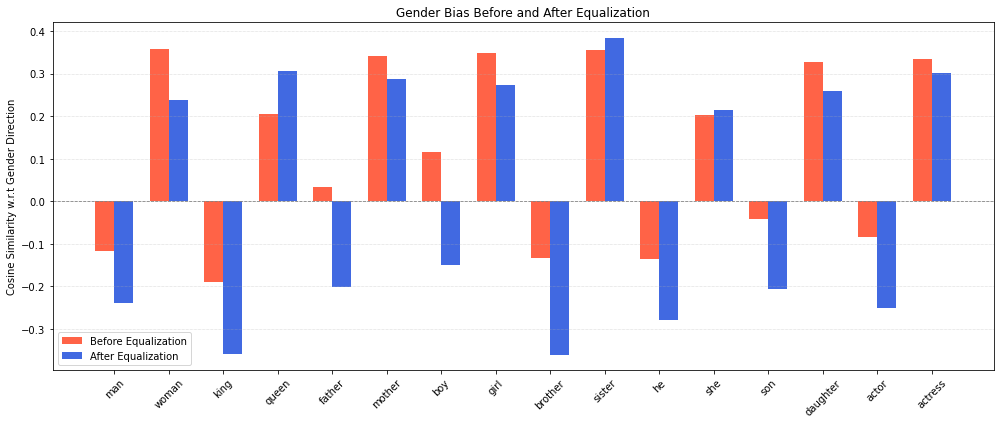

In [94]:
pairs = pairs_to_test.copy()

before_vals = []
after_vals = []
labels = []

# Collect cosine similarities before and after equalization
for w1, w2 in pairs:
    before_vals.append(cosine_similarity(word_to_vec_map[w1], g))
    before_vals.append(cosine_similarity(word_to_vec_map[w2], g))
    
    e1, e2 = equalize((w1, w2), g_unit, word_to_vec_map_unit_vectors)
    after_vals.append(cosine_similarity(e1, g_unit))
    after_vals.append(cosine_similarity(e2, g_unit))
    
    labels.extend([w1, w2])

x = np.arange(len(labels)) 
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width/2, before_vals, width, label='Before Equalization', color='tomato')
bars2 = ax.bar(x + width/2, after_vals, width, label='After Equalization', color='royalblue')

ax.set_ylabel('Cosine Similarity w.r.t Gender Direction')
ax.set_title('Gender Bias Before and After Equalization')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle=':', linewidth=0.5)

plt.show()